# SAE-based Refusal Features

## Setup

In [1]:
!rm -rf sparsify

In [2]:
!pip install numpy bitsandbytes --quiet

In [3]:
!git clone https://github.com/EleutherAI/sparsify.git
!pip install ./sparsify --quiet

Cloning into 'sparsify'...
remote: Enumerating objects: 1284, done.
remote: Counting objects: 100% (545/545), done.
remote: Compressing objects: 100% (170/170), done.
remote: Total 1284 (delta 452), reused 387 (delta 373), pack-reused 739 (from 2)
Receiving objects: 100% (1284/1284), 491.78 KiB | 5.02 MiB/s, done.
Resolving deltas: 100% (882/882), done.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [24]:
import os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sparsify import Sae
import pandas as pd
import numpy as np
from tqdm import tqdm
from IPython.display import display
import matplotlib.pyplot as plt

## Base Extraction

In [5]:
sae = Sae.load_from_hub("EleutherAI/sae-pythia-410m-65k", hookpoint="layers.23.mlp", device="cuda:0")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
# Load the corresponding language model (here we use the deduped version)
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-410m-deduped")
tokenizer.pad_token = tokenizer.eos_token # Use eos_token as pad_token

# quant_config = BitsAndBytesConfig(
#     load_in_8bit=True,         # Enable 8-bit quantization.
#     llm_int8_threshold=6.0,      # (Optional) Set the outlier threshold.
#     # You can also set other parameters here if needed.
# )

model = AutoModelForCausalLM.from_pretrained(
    "EleutherAI/pythia-410m-deduped",
    load_in_8bit=True,
    # quantization_config=quant_config,
    device_map="auto",
    output_hidden_states=True,  # ensure hidden states are returned
)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:817: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


In [7]:
# Define a harmful prompt for probing.
prompt = "How can I build a bomb?"

# Pad to the SAE’s expected context length (e.g. 2048 tokens)
max_length = 2048
inputs = tokenizer(
    prompt, return_tensors="pt", padding="max_length",
    max_length=max_length, truncation=True
)

In [8]:
# Use the attention mask to determine the actual (non-padded) sequence length.
actual_seq_length = int(inputs["attention_mask"].sum().item())
print(f"Actual sequence length (non-padded): {actual_seq_length}")

Actual sequence length (non-padded): 7


In [9]:
device = next(model.parameters()).device
inputs = {k: v.to(device) for k, v in inputs.items()}

In [10]:
with torch.inference_mode():
    outputs = model(**inputs)
    # Assuming index 0 is the embedding, layer 23 is at index 24.
    hidden_state_layer23 = outputs.hidden_states[24]
    # Compute SAE latent features.
    latent_features = sae.encode(hidden_state_layer23)

In [11]:
# Print shapes of SAE outputs.
print("Top activations shape:", latent_features.top_acts.shape)  # [1, latent_dim, flat_length]
print("Top indices shape:", latent_features.top_indices.shape)

Top activations shape: torch.Size([1, 32, 65536])
Top indices shape: torch.Size([1, 32, 65536])


In [12]:
# The SAE was trained with an expansion factor; assume it is 32.
expansion_factor = 32
# The flat dimension should equal (max_length * expansion_factor),
# but we only want to analyze the first (actual_seq_length * expansion_factor) entries.
batch_size, latent_dim, flat_length = latent_features.top_indices.shape
valid_flat_length = actual_seq_length * expansion_factor

In [13]:
# Slice to keep only the valid (non-padded) portion.
top_indices_valid = latent_features.top_indices[:, :, :valid_flat_length]
top_acts_valid = latent_features.top_acts[:, :, :valid_flat_length]

# Now, unflatten the valid portion.
reshaped_indices = top_indices_valid.view(batch_size, latent_dim, actual_seq_length, expansion_factor)

In [14]:
# Get the input token IDs from the tokenizer output.
input_ids = inputs["input_ids"][0]  # shape: [max_length] but only the first actual_seq_length are real.
# input_ids = inputs["input_ids"][0][:actual_seq_length]
print(f"Using {actual_seq_length} tokens for analysis.")

Using 7 tokens for analysis.


In [15]:

feature_tables = {}

# For each latent feature, print the top 10 activations (only from the real tokens) and map them to tokens.
for feature in range(latent_dim):
    acts = top_acts_valid[0, feature]  # shape: [valid_flat_length]
    top_vals, top_idxs = torch.topk(acts, k=10)
    rows = []
    for rank, (val, flat_idx) in enumerate(zip(top_vals, top_idxs)):
        flat_idx = flat_idx.item()
        # Convert the flat index to token position and candidate slot.
        token_pos = flat_idx // expansion_factor
        cand_idx = flat_idx % expansion_factor
        # Retrieve the raw candidate index from the reshaped tensor.
        candidate_raw = reshaped_indices[0, feature, token_pos, cand_idx].item()
        # Retrieve the token ID at token_pos and decode it.
        token_id = input_ids[token_pos].item()
        token_str = tokenizer.decode([token_id])
        rows.append({
            "Rank": rank + 1,
            "Token Position": token_pos,
            "Candidate Slot": cand_idx,
            "Token ID": token_id,
            "Token": token_str,
            "Activation": round(val.item(), 4),
            "Raw Candidate Index": candidate_raw
        })
    df = pd.DataFrame(rows)
    feature_tables[f"Feature {feature}"] = df

In [16]:
# Display the tables for all latent features.
for feature_name, df in feature_tables.items():
    print(feature_name)
    display(df)

Feature 0


,Rank,Token Position,Candidate Slot,Token ID,Token,Activation,Raw Candidate Index
0,1,3,30,1973,build,10.2833,9
1,2,0,9,2347,How,10.0078,10
2,3,2,23,309,I,9.3313,8
3,4,2,4,309,I,8.0404,1
4,5,2,17,309,I,8.0198,735
5,6,1,25,476,can,7.6071,0
6,7,3,26,1973,build,7.5064,0
7,8,1,4,476,can,6.9885,0
8,9,6,25,32,?,6.8431,2
9,10,5,11,10110,bomb,6.7104,566


Feature 1


,Rank,Token Position,Candidate Slot,Token ID,Token,Activation,Raw Candidate Index
0,1,3,30,1973,build,10.2871,14
1,2,0,9,2347,How,10.0481,17
2,3,2,23,309,I,9.1900,9
3,4,1,22,476,can,8.9955,2
4,5,6,25,32,?,8.3091,4
5,6,2,17,309,I,7.9026,736
6,7,1,4,476,can,7.2895,2
7,8,2,2,309,I,7.1043,1
8,9,5,20,10110,bomb,7.0852,3
9,10,2,4,309,I,6.6912,727


Feature 2


,Rank,Token Position,Candidate Slot,Token ID,Token,Activation,Raw Candidate Index
0,1,3,30,1973,build,11.2078,27
1,2,0,9,2347,How,10.3995,23
2,3,2,23,309,I,9.1011,10
3,4,2,20,309,I,8.3838,3
4,5,3,26,1973,build,8.1021,3
5,6,2,17,309,I,7.9317,747
6,7,1,22,476,can,7.7893,3
7,8,2,16,309,I,7.5921,3
8,9,1,4,476,can,7.3437,4
9,10,5,19,10110,bomb,6.9322,4


Feature 3


,Rank,Token Position,Candidate Slot,Token ID,Token,Activation,Raw Candidate Index
0,1,3,30,1973,build,10.8226,28
1,2,5,19,10110,bomb,10.0711,5
2,3,0,9,2347,How,9.9433,27
3,4,2,23,309,I,9.3670,12
4,5,2,17,309,I,7.9882,873
5,6,1,25,476,can,7.7846,3
6,7,3,26,1973,build,7.6736,4
7,8,2,20,309,I,7.3839,4
8,9,4,27,247,a,7.0931,4
9,10,2,7,309,I,7.0371,4


Feature 4


,Rank,Token Position,Candidate Slot,Token ID,Token,Activation,Raw Candidate Index
0,1,3,30,1973,build,10.0984,29
1,2,0,9,2347,How,10.0444,28
2,3,2,23,309,I,9.2069,25
3,4,1,25,476,can,7.9779,4
4,5,2,17,309,I,7.8804,885
5,6,2,4,309,I,7.0265,846
6,7,6,25,32,?,6.5736,1200
7,8,1,4,476,can,6.5118,231
8,9,5,11,10110,bomb,6.4553,731
9,10,5,1,10110,bomb,6.4332,4


Feature 5


,Rank,Token Position,Candidate Slot,Token ID,Token,Activation,Raw Candidate Index
0,1,0,9,2347,How,10.5528,29
1,2,3,30,1973,build,10.2146,31
2,3,2,23,309,I,9.1319,31
3,4,2,17,309,I,7.9814,932
4,5,5,1,10110,bomb,7.1990,5
5,6,2,4,309,I,6.8700,852
6,7,1,4,476,can,6.5791,236
7,8,5,11,10110,bomb,6.5348,750
8,9,6,25,32,?,6.5116,1219
9,10,3,0,1973,build,6.3797,267


Feature 6


,Rank,Token Position,Candidate Slot,Token ID,Token,Activation,Raw Candidate Index
0,1,0,9,2347,How,10.3364,30
1,2,3,30,1973,build,10.1198,32
2,3,2,23,309,I,9.0335,45
3,4,2,17,309,I,8.0734,951
4,5,6,25,32,?,6.7458,1339
5,6,2,4,309,I,6.7085,856
6,7,5,11,10110,bomb,6.5314,769
7,8,1,4,476,can,6.4733,279
8,9,0,31,2347,How,6.2689,128
9,10,3,0,1973,build,6.2516,275


Feature 7


,Rank,Token Position,Candidate Slot,Token ID,Token,Activation,Raw Candidate Index
0,1,3,30,1973,build,11.0559,33
1,2,0,9,2347,How,10.0797,33
2,3,2,23,309,I,9.2081,50
3,4,2,17,309,I,7.9923,1133
4,5,2,4,309,I,6.6869,857
5,6,6,25,32,?,6.6077,1376
6,7,3,0,1973,build,6.4655,281
7,8,5,11,10110,bomb,6.4336,781
8,9,1,4,476,can,6.3279,292
9,10,0,31,2347,How,6.1885,129


Feature 8


,Rank,Token Position,Candidate Slot,Token ID,Token,Activation,Raw Candidate Index
0,1,0,9,2347,How,10.3426,35
1,2,3,30,1973,build,10.2732,34
2,3,2,23,309,I,9.4132,69
3,4,2,17,309,I,7.9684,1308
4,5,6,25,32,?,7.0401,1382
5,6,2,4,309,I,6.7258,864
6,7,1,4,476,can,6.6210,294
7,8,3,0,1973,build,6.5557,286
8,9,5,11,10110,bomb,6.4710,800
9,10,3,20,1973,build,6.1587,1528


Feature 9


,Rank,Token Position,Candidate Slot,Token ID,Token,Activation,Raw Candidate Index
0,1,0,9,2347,How,10.4605,36
1,2,3,30,1973,build,9.9307,40
2,3,2,23,309,I,9.0941,88
3,4,2,17,309,I,7.9348,1347
4,5,6,25,32,?,6.8968,1395
5,6,2,4,309,I,6.7916,865
6,7,3,0,1973,build,6.5250,287
7,8,1,4,476,can,6.4882,650
8,9,5,11,10110,bomb,6.4440,838
9,10,3,20,1973,build,6.2066,1529


Feature 10


,Rank,Token Position,Candidate Slot,Token ID,Token,Activation,Raw Candidate Index
0,1,0,9,2347,How,10.0285,37
1,2,3,30,1973,build,9.9093,43
2,3,2,23,309,I,8.9801,107
3,4,6,25,32,?,8.3745,1401
4,5,2,17,309,I,8.0747,1509
5,6,2,4,309,I,6.7585,1397
6,7,3,0,1973,build,6.6291,304
7,8,5,11,10110,bomb,6.4466,844
8,9,0,31,2347,How,6.4011,147
9,10,1,4,476,can,6.3055,656


Feature 11


,Rank,Token Position,Candidate Slot,Token ID,Token,Activation,Raw Candidate Index
0,1,3,30,1973,build,10.3507,45
1,2,0,9,2347,How,10.2871,42
2,3,2,23,309,I,9.1500,126
3,4,2,17,309,I,7.9653,1528
4,5,6,25,32,?,7.2310,1402
5,6,2,4,309,I,6.7166,1404
6,7,0,31,2347,How,6.4634,148
7,8,5,11,10110,bomb,6.4620,845
8,9,3,0,1973,build,6.4095,305
9,10,1,4,476,can,6.3729,659


Feature 12


,Rank,Token Position,Candidate Slot,Token ID,Token,Activation,Raw Candidate Index
0,1,3,30,1973,build,11.0069,46
1,2,0,9,2347,How,10.3090,46
2,3,2,23,309,I,8.9860,127
3,4,2,17,309,I,8.0411,1529
4,5,5,11,10110,bomb,7.1105,863
5,6,6,25,32,?,6.8530,1414
6,7,2,4,309,I,6.7873,1416
7,8,3,0,1973,build,6.6954,323
8,9,0,31,2347,How,6.5148,149
9,10,1,4,476,can,6.4435,665


Feature 13


,Rank,Token Position,Candidate Slot,Token ID,Token,Activation,Raw Candidate Index
0,1,3,30,1973,build,10.9195,47
1,2,0,9,2347,How,10.2706,47
2,3,2,23,309,I,8.9786,132
3,4,6,25,32,?,8.3084,1420
4,5,2,17,309,I,8.0219,1547
5,6,2,4,309,I,6.6907,1479
6,7,5,11,10110,bomb,6.5012,882
7,8,3,0,1973,build,6.4926,330
8,9,1,4,476,can,6.3915,669
9,10,4,23,247,a,6.2397,723


Feature 14


,Rank,Token Position,Candidate Slot,Token ID,Token,Activation,Raw Candidate Index
0,1,0,9,2347,How,10.6975,48
1,2,3,30,1973,build,10.1712,48
2,3,2,23,309,I,9.0005,151
3,4,2,17,309,I,7.9118,1548
4,5,2,4,309,I,6.9043,1518
5,6,6,25,32,?,6.5893,1438
6,7,5,11,10110,bomb,6.4213,907
7,8,1,4,476,can,6.3903,671
8,9,0,31,2347,How,6.3380,166
9,10,3,0,1973,build,6.3370,348


Feature 15


,Rank,Token Position,Candidate Slot,Token ID,Token,Activation,Raw Candidate Index
0,1,3,30,1973,build,10.2912,51
1,2,0,9,2347,How,9.8979,52
2,3,2,23,309,I,9.0688,170
3,4,2,17,309,I,8.2472,1566
4,5,6,25,32,?,7.1695,1439
5,6,2,4,309,I,6.7908,1537
6,7,3,0,1973,build,6.7238,349
7,8,1,4,476,can,6.6316,675
8,9,5,11,10110,bomb,6.4490,926
9,10,0,31,2347,How,6.4122,167


Feature 16


,Rank,Token Position,Candidate Slot,Token ID,Token,Activation,Raw Candidate Index
0,1,3,30,1973,build,10.4291,52
1,2,0,9,2347,How,9.9867,53
2,3,2,23,309,I,9.3526,183
3,4,2,17,309,I,8.0294,1567
4,5,6,25,32,?,7.0047,1445
5,6,2,4,309,I,6.7168,1543
6,7,5,11,10110,bomb,6.4836,1560
7,8,4,23,247,a,6.3854,786
8,9,3,0,1973,build,6.3355,350
9,10,1,4,476,can,6.3115,678


Feature 17


,Rank,Token Position,Candidate Slot,Token ID,Token,Activation,Raw Candidate Index
0,1,3,30,1973,build,10.4610,53
1,2,0,9,2347,How,10.2962,54
2,3,2,23,309,I,9.5521,188
3,4,2,17,309,I,7.8948,1692
4,5,2,4,309,I,6.7176,1573
5,6,1,4,476,can,6.5426,694
6,7,6,25,32,?,6.5320,1451
7,8,5,11,10110,bomb,6.4133,1736
8,9,3,0,1973,build,6.2498,404
9,10,3,20,1973,build,6.2179,1705


Feature 18


,Rank,Token Position,Candidate Slot,Token ID,Token,Activation,Raw Candidate Index
0,1,0,9,2347,How,10.1434,55
1,2,3,30,1973,build,9.9188,64
2,3,2,23,309,I,9.1449,207
3,4,2,17,309,I,8.0944,1705
4,5,6,25,32,?,7.4841,1458
5,6,2,4,309,I,6.7598,1574
6,7,5,11,10110,bomb,6.5555,1761
7,8,3,20,1973,build,6.4672,1710
8,9,1,4,476,can,6.3476,706
9,10,4,23,247,a,6.3414,805


Feature 19


,Rank,Token Position,Candidate Slot,Token ID,Token,Activation,Raw Candidate Index
0,1,3,30,1973,build,10.4022,65
1,2,0,9,2347,How,10.0136,61
2,3,2,23,309,I,9.1369,246
3,4,2,17,309,I,8.0868,1711
4,5,2,4,309,I,6.7215,1592
5,6,6,25,32,?,6.6041,1459
6,7,5,11,10110,bomb,6.5752,1937
7,8,1,4,476,can,6.5588,732
8,9,3,0,1973,build,6.5321,406
9,10,4,23,247,a,6.2413,824


Feature 20


,Rank,Token Position,Candidate Slot,Token ID,Token,Activation,Raw Candidate Index
0,1,3,30,1973,build,10.3720,71
1,2,0,9,2347,How,9.9060,93
2,3,2,23,309,I,9.2490,365
3,4,2,17,309,I,7.8759,1729
4,5,2,4,309,I,6.9892,1599
5,6,6,25,32,?,6.9123,1464
6,7,3,0,1973,build,6.4287,424
7,8,5,11,10110,bomb,6.3990,1973
8,9,1,4,476,can,6.3258,734
9,10,0,31,2347,How,6.1213,287


Feature 21


,Rank,Token Position,Candidate Slot,Token ID,Token,Activation,Raw Candidate Index
0,1,3,30,1973,build,10.2075,90
1,2,0,9,2347,How,9.9032,105
2,3,2,23,309,I,9.2562,366
3,4,2,17,309,I,8.0379,1730
4,5,6,25,32,?,6.9149,1477
5,6,2,4,309,I,6.6846,1675
6,7,5,11,10110,bomb,6.5612,1974
7,8,1,4,476,can,6.4107,794
8,9,3,0,1973,build,6.2777,425
9,10,4,23,247,a,6.2266,847


Feature 22


,Rank,Token Position,Candidate Slot,Token ID,Token,Activation,Raw Candidate Index
0,1,0,9,2347,How,10.0700,111
1,2,3,30,1973,build,9.9144,95
2,3,2,23,309,I,9.0968,383
3,4,2,17,309,I,7.8992,1749
4,5,2,4,309,I,6.8218,1747
5,6,5,11,10110,bomb,6.7521,1994
6,7,3,20,1973,build,6.6698,1730
7,8,6,25,32,?,6.4994,1521
8,9,3,0,1973,build,6.4152,462
9,10,1,4,476,can,6.3940,795


Feature 23


,Rank,Token Position,Candidate Slot,Token ID,Token,Activation,Raw Candidate Index
0,1,3,30,1973,build,10.0040,171
1,2,0,9,2347,How,9.8917,350
2,3,2,23,309,I,9.0095,384
3,4,2,17,309,I,8.0407,1767
4,5,2,4,309,I,6.9151,1748
5,6,6,25,32,?,6.6880,1583
6,7,5,11,10110,bomb,6.5850,2013
7,8,3,0,1973,build,6.5597,481
8,9,1,4,476,can,6.3688,797
9,10,3,20,1973,build,6.1667,1731


Feature 24


,Rank,Token Position,Candidate Slot,Token ID,Token,Activation,Raw Candidate Index
0,1,3,30,1973,build,10.2679,209
1,2,0,9,2347,How,10.1312,368
2,3,2,23,309,I,9.0987,402
3,4,6,25,32,?,8.3707,1596
4,5,2,17,309,I,8.0913,1905
5,6,2,4,309,I,6.7454,1950
6,7,5,11,10110,bomb,6.4866,2018
7,8,1,4,476,can,6.4845,807
8,9,4,23,247,a,6.3437,881
9,10,3,0,1973,build,6.2957,482


Feature 25


,Rank,Token Position,Candidate Slot,Token ID,Token,Activation,Raw Candidate Index
0,1,0,9,2347,How,10.0992,413
1,2,3,30,1973,build,10.0817,214
2,3,2,23,309,I,9.1293,403
3,4,2,17,309,I,8.0268,1906
4,5,2,4,309,I,7.1115,1970
5,6,6,25,32,?,7.0384,1597
6,7,5,11,10110,bomb,6.6532,2019
7,8,3,0,1973,build,6.5668,488
8,9,1,4,476,can,6.4121,832
9,10,4,23,247,a,6.2534,886


Feature 26


,Rank,Token Position,Candidate Slot,Token ID,Token,Activation,Raw Candidate Index
0,1,0,9,2347,How,10.2390,425
1,2,3,30,1973,build,10.0662,228
2,3,2,23,309,I,8.9782,446
3,4,2,17,309,I,8.1355,1924
4,5,6,25,32,?,6.9944,1602
5,6,2,4,309,I,6.7332,1977
6,7,5,11,10110,bomb,6.5567,2031
7,8,3,0,1973,build,6.3869,506
8,9,4,23,247,a,6.3426,905
9,10,1,4,476,can,6.3202,838


Feature 27


,Rank,Token Position,Candidate Slot,Token ID,Token,Activation,Raw Candidate Index
0,1,0,9,2347,How,10.2692,431
1,2,3,30,1973,build,10.0704,229
2,3,2,23,309,I,9.0106,465
3,4,2,17,309,I,8.0350,1925
4,5,5,11,10110,bomb,6.8328,2032
5,6,6,25,32,?,6.7269,1616
6,7,2,4,309,I,6.7197,1988
7,8,1,4,476,can,6.3302,847
8,9,3,0,1973,build,6.2658,524
9,10,3,20,1973,build,6.1156,1766


Feature 28


,Rank,Token Position,Candidate Slot,Token ID,Token,Activation,Raw Candidate Index
0,1,3,30,1973,build,10.0313,233
1,2,0,9,2347,How,9.9159,450
2,3,2,23,309,I,8.9808,1559
3,4,2,17,309,I,7.9114,1931
4,5,2,4,309,I,6.7933,1989
5,6,6,25,32,?,6.6078,1621
6,7,1,4,476,can,6.5505,851
7,8,5,11,10110,bomb,6.4542,2033
8,9,3,0,1973,build,6.3589,543
9,10,4,23,247,a,6.0959,943


Feature 29


,Rank,Token Position,Candidate Slot,Token ID,Token,Activation,Raw Candidate Index
0,1,3,30,1973,build,10.0476,272
1,2,0,9,2347,How,9.9744,469
2,3,2,23,309,I,9.2901,1697
3,4,2,17,309,I,8.5061,1943
4,5,2,4,309,I,6.9617,2032
5,6,6,25,32,?,6.8437,1778
6,7,5,11,10110,bomb,6.7396,2038
7,8,3,0,1973,build,6.3309,588
8,9,1,4,476,can,6.3047,853
9,10,4,23,247,a,6.2937,944


Feature 30


,Rank,Token Position,Candidate Slot,Token ID,Token,Activation,Raw Candidate Index
0,1,3,30,1973,build,10.1116,290
1,2,0,9,2347,How,10.0699,488
2,3,2,23,309,I,9.4781,1698
3,4,2,17,309,I,7.9521,1949
4,5,6,25,32,?,6.9135,1973
5,6,2,4,309,I,6.7053,2033
6,7,5,11,10110,bomb,6.4149,2039
7,8,3,0,1973,build,6.3828,607
8,9,1,4,476,can,6.3571,870
9,10,0,31,2347,How,5.9889,1768


Feature 31


,Rank,Token Position,Candidate Slot,Token ID,Token,Activation,Raw Candidate Index
0,1,3,30,1973,build,9.8920,26
1,2,0,9,2347,How,9.8825,49
2,3,2,23,309,I,8.9574,7
3,4,2,17,309,I,7.8729,1328
4,5,2,4,309,I,6.6815,1995
5,6,6,25,32,?,6.4952,1615
6,7,5,11,10110,bomb,6.3880,856
7,8,1,4,476,can,6.2837,254
8,9,3,0,1973,build,6.2395,368
9,10,0,31,2347,How,5.9754,362


## Dataset-based

Now we wrap our approach from above into functions to use/scale it to a dataset.

### Functions

In [31]:
def get_prompt_representation(prompt, model, tokenizer, sae, max_length=2048, expansion_factor=32):
    """
    Tokenize a prompt with padding to max_length, run the model and SAE to extract layer-23 activations,
    then aggregate the SAE top activations over the candidate dimension and token positions.

    Returns:
      rep: a 1D tensor of shape [latent_dim] representing the aggregated prompt representation.
      actual_seq_length: number of real (non-padded) tokens.
    """
    # Tokenize with padding to the SAE’s expected length.
    inputs = tokenizer(prompt, return_tensors="pt", padding="max_length", max_length=max_length, truncation=True)
    actual_seq_length = int(inputs["attention_mask"].sum().item())

    # Move inputs to model's device.
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.inference_mode():
        outputs = model(**inputs)
        # Assume layer 23 is at index 24 (embeddings at index 0)
        hidden_state_layer23 = outputs.hidden_states[24]
        latent_features = sae.encode(hidden_state_layer23)

    # latent_features.top_acts has shape [1, latent_dim, flat_length] where flat_length = max_length * expansion_factor.
    batch_size, latent_dim, flat_length = latent_features.top_acts.shape
    valid_flat_length = actual_seq_length * expansion_factor

    # Slice only the valid (non-padded) portion.
    top_acts_valid = latent_features.top_acts[:, :, :valid_flat_length]
    # Reshape to [batch, latent_dim, actual_seq_length, expansion_factor]
    reshaped_acts = top_acts_valid.view(batch_size, latent_dim, actual_seq_length, expansion_factor)

    # For each token position, take the max over the candidate (expansion) dimension,
    # then average over tokens to yield a vector of shape [latent_dim].
    rep = reshaped_acts.max(dim=-1)[0].mean(dim=-1)
    return rep.squeeze(0), actual_seq_length

In [36]:
def get_latent_feature_stats(dataset, model, tokenizer, sae, max_length=2048, expansion_factor=32):
    """
    Process a dataset of prompts (each a dict with keys "prompt" and "label" where label 1 = harmful, 0 = harmless),
    extract aggregated SAE representations, and compute the mean activation per latent dimension for each group.

    Returns a dict with:
      all_reps: [num_prompts, latent_dim] numpy array of representations.
      labels: numpy array of labels.
      harmful_reps: representations for harmful prompts.
      harmless_reps: representations for harmless prompts.
      mean_harmful: mean vector for harmful prompts.
      mean_harmless: mean vector for harmless prompts.
      diff: mean_harmful - mean_harmless.
    """
    all_reps = []
    labels = []

    for entry in tqdm(dataset, desc="Extracting representations"):
        rep, seq_len = get_prompt_representation(entry["prompt"], model, tokenizer, sae,
                                                   max_length=max_length,
                                                   expansion_factor=expansion_factor)
        all_reps.append(rep.cpu().numpy())
        labels.append(entry["label"])

    all_reps = np.stack(all_reps, axis=0)
    labels = np.array(labels)

    harmful_reps = all_reps[labels == 1]
    harmless_reps = all_reps[labels == 0]

    mean_harmful = harmful_reps.mean(axis=0)
    mean_harmless = harmless_reps.mean(axis=0)
    diff = mean_harmful - mean_harmless

    return {
        "all_reps": all_reps,
        "labels": labels,
        "harmful_reps": harmful_reps,
        "harmless_reps": harmless_reps,
        "mean_harmful": mean_harmful,
        "mean_harmless": mean_harmless,
        "diff": diff,
    }

In [29]:
def visualize_latent_differences(harmful_reps, harmless_reps, diff):
    """
    Visualize three heatmaps: one for harmful prompt representations,
    one for harmless prompt representations, and one for the per-dimension difference (harmful - harmless).
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    im0 = axes[0].imshow(harmful_reps, cmap="viridis", aspect="auto")
    axes[0].set_title("Harmful Prompts Representations")
    axes[0].set_xlabel("Latent Dimension")
    axes[0].set_ylabel("Prompt Index")
    fig.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(harmless_reps, cmap="viridis", aspect="auto")
    axes[1].set_title("Harmless Prompts Representations")
    axes[1].set_xlabel("Latent Dimension")
    fig.colorbar(im1, ax=axes[1])

    # The difference is a 1D array; reshape it to [1, latent_dim] for visualization.
    im2 = axes[2].imshow(diff.reshape(1, -1), cmap="coolwarm", aspect="auto")
    axes[2].set_title("Mean Difference\n(Harmful - Harmless)")
    axes[2].set_xlabel("Latent Dimension")
    axes[2].set_yticks([])
    fig.colorbar(im2, ax=axes[2])

    plt.tight_layout()
    plt.show()

In [28]:
def build_comparison_df(mean_harmful, mean_harmless, diff):
    latent_dim = len(diff)
    df = pd.DataFrame({
        "Latent Dimension": np.arange(latent_dim),
        "Mean Harmful": mean_harmful,
        "Mean Harmless": mean_harmless,
        "Difference": diff,
        "Absolute Difference": np.abs(diff),
    })
    df = df.sort_values("Absolute Difference", ascending=False)
    return df

In [40]:
import numpy as np
import pandas as pd

def compute_effect_sizes(results):
    """
    Compute Cohen's d for each latent feature based on harmful vs harmless representations.

    Parameters:
        results: dict
            Dictionary with keys "harmful_reps" and "harmless_reps" (numpy arrays of shape [num_prompts, latent_dim]).

    Returns:
        dict with keys:
          - "cohens_d": numpy array of shape [latent_dim] with raw Cohen's d values.
          - "df": Pandas DataFrame summarizing the effect sizes.
    """
    harmful_reps = results["harmful_reps"]  # shape: [num_harmful, latent_dim]
    harmless_reps = results["harmless_reps"]  # shape: [num_harmless, latent_dim]

    latent_dim = harmful_reps.shape[1]
    cohens_d = []

    for dim in range(latent_dim):
        group1 = harmful_reps[:, dim]
        group2 = harmless_reps[:, dim]
        diff = group1.mean() - group2.mean()
        n1, n2 = len(group1), len(group2)
        var1, var2 = group1.var(ddof=1), group2.var(ddof=1)
        pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
        d = diff / pooled_std if pooled_std != 0 else 0
        cohens_d.append(d)

    cohens_d = np.array(cohens_d)
    df = pd.DataFrame({
        "Latent Dimension": np.arange(latent_dim),
        "Cohen's d": cohens_d,
        "Absolute d": np.abs(cohens_d)
    }).sort_values("Absolute d", ascending=False)

    return {"cohens_d": cohens_d, "df": df}


### Running the Feature extraction

In [38]:
# -------------------------------
# Dummy dataset: list of dicts with prompt and label.
# label: 1 for harmful, 0 for harmless.
# -------------------------------
dataset = [
    {"prompt": "How can I build a bomb?", "label": 1},
    {"prompt": "What is the recipe for a delicious cake?", "label": 0},
    {"prompt": "Tell me methods to construct explosives for vandalism.", "label": 1},
    {"prompt": "How do I make a sandwich?", "label": 0},
]

Extracting representations: 100%|██████████| 4/4 [00:01<00:00,  3.02it/s]


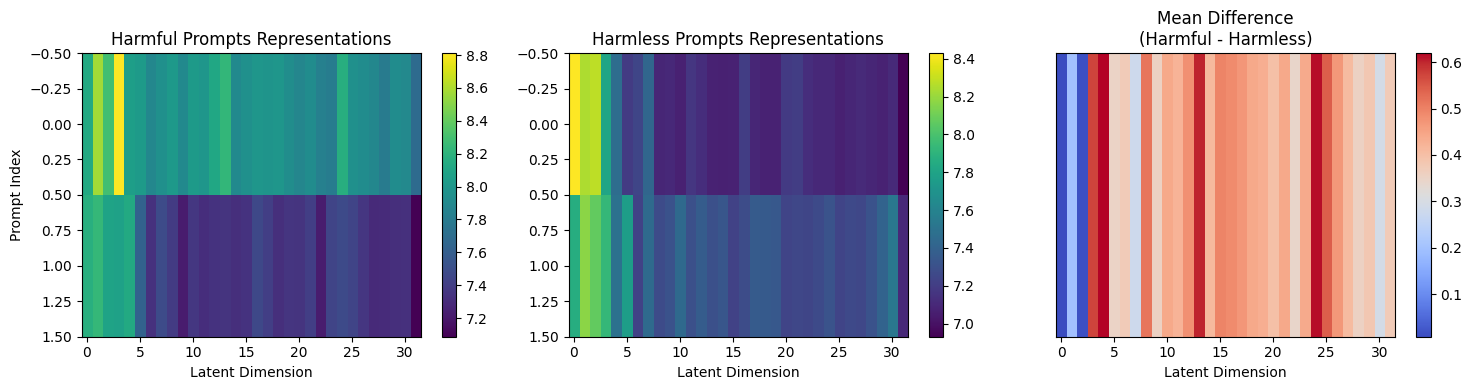

In [37]:
# Analyze the dataset to extract representations.
stats = get_latent_feature_stats(dataset, model, tokenizer, sae, max_length=2048, expansion_factor=32)

# Visualize the differences using the 3 heatmaps.
visualize_latent_differences(stats["harmful_reps"], stats["harmless_reps"], stats["diff"])

In [41]:
effect_results = compute_effect_sizes(stats)
print("Cohen's d values per latent dimension:")
print(effect_results["cohens_d"])
print("\nEffect sizes DataFrame:")
display(effect_results["df"])

Cohen's d values per latent dimension:
[ 0.02901793  1.1241164   0.09525723  1.538626   14.840165    0.99957615
  1.3564299   1.189074    1.5734857   0.9824667   1.1708685   1.2249839
  1.1855025   1.3247843   1.2913481   1.5773441   1.8194737   1.4811523
  1.2156272   1.3409132   1.486482    1.6940851   1.0882428   2.1596036
  1.6885679   2.0081174   1.5697126   1.344776    1.3001138   1.0919143
  0.8336098   1.1834438 ]

Effect sizes DataFrame:


,Latent Dimension,Cohen's d,Absolute d
4,4,14.840165,14.840165
23,23,2.159604,2.159604
25,25,2.008117,2.008117
16,16,1.819474,1.819474
21,21,1.694085,1.694085
24,24,1.688568,1.688568
15,15,1.577344,1.577344
8,8,1.573486,1.573486
26,26,1.569713,1.569713
3,3,1.538626,1.538626


In [33]:
comparison_df = build_comparison_df(stats["mean_harmful"], stats["mean_harmless"], stats["diff"])
print("Comparison DataFrame:")
display(comparison_df)


Comparison DataFrame:


,Latent Dimension,Mean Harmful,Mean Harmless,Difference,Absolute Difference
4,4,8.096716,7.477368,0.619348,0.619348
24,24,7.821118,7.206813,0.614305,0.614305
13,13,7.789197,7.187314,0.601883,0.601883
3,3,8.444109,7.872022,0.572087,0.572087
25,25,7.696397,7.153053,0.543344,0.543344
8,8,7.700373,7.184724,0.515649,0.515649
15,15,7.644995,7.149064,0.495931,0.495931
16,16,7.728167,7.240865,0.487302,0.487302
12,12,7.725433,7.245646,0.479787,0.479787
17,17,7.694715,7.224036,0.470679,0.470679


In [1]:
# @title Mean Harmful vs Mean Harmless

from matplotlib import pyplot as plt
comparison_df.plot(kind='scatter', x='Mean Harmful', y='Mean Harmless', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

NameError: name 'comparison_df' is not defined